# General Purpose Visualization Notebook

## Visualize Uncertainty Quantifications
Assumes `run_experiments` has generated results in the `[EXP_FOLDER]/results` folder.

In [1]:
%load_ext autoreload
%autoreload 2
EXP_FOLDER = 'cifar10'

In [7]:
import sys
import os
sys.path.append(os.path.abspath(EXP_FOLDER))
import config # imported from EXP_FOLDER

import numpy as np
import glob
import torch

import matplotlib 
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 
import matplotlib.pyplot as plt

from ipywidgets import interact

from nn_ood.utils.viz import plot_histogram, plot_scatter, plot_rocs_by_error, plot_binned_by_unc, plot_times, summarize_ood_results, summarize_ood_results_by_error, plot_perf_vs_runtime, plot_rocs_by_dist, generate_table_block
from nn_ood.utils.viz import plot_transform_sweep
from nn_ood.utils.inspect import norm_by_param

In [3]:
results_dict = {}
folder_path = os.path.join(EXP_FOLDER, "results","*")
for filename in glob.glob(folder_path):
    name = os.path.basename(filename)
    results_dict[name] = torch.load(filename)

## Load Models

In [4]:
# load base model
print("Loading models")
models = []
for i in range(config.N_MODELS):
    print("loading model %d" % i)
    filename = os.path.join(EXP_FOLDER, 'models', config.FILENAME + "_%d" % i)
    state_dict = torch.load(filename)
    model = config.make_model()
    model.load_state_dict(state_dict)
    model.to(config.device)
    model.eval()
    models.append(model)
    plt.show()

model = models[0]

## Ask which uncertainty model to use for viz
import ipywidgets as widgets
names = list(config.test_unc_models.keys())
name_widget = widgets.Dropdown(
    options=names,
    value=names[0],
    description='Uncertainty Model:',
    disabled=False,
)
name_widget

Loading models
loading model 0


Dropdown(description='Uncertainty Model:', options=('kfac_n1e6_s5000',), value='kfac_n1e6_s5000')

In [6]:
# load unc model
name = name_widget.value
info = config.test_unc_models[name]   
print(info)

config.unfreeze_model(model)
if 'freeze' in info:
    if type(info['freeze']) is bool:
        freeze_frac = None
    else:
        freeze_frac = info['freeze']
    config.freeze_model(model, freeze_frac=freeze_frac)     

if 'apply_fn' is info:
    model.apply(info['apply_fn'])

if 'multi_model' in info:
    unc_model = info['class'](models, config.dist_constructor, info['kwargs'])
else:
    unc_model = info['class'](model, config.dist_constructor, info['kwargs'])

if info['load_name'] is not None: 
    filename = os.path.join(EXP_FOLDER, "models", info['load_name']+"_"+config.FILENAME)
    unc_model.load_state_dict(torch.load(filename), strict=False)

{'class': <class 'scod.scod.SCOD'>, 'kwargs': {'num_eigs': 100, 'device': 'gpu'}, 'load_name': 'scod_SRFT_s604_n100', 'forward_kwargs': {'n_eigs': 300}}


AttributeError: module 'config' has no attribute 'dist_fam'

## Visualize Samples from Dataset

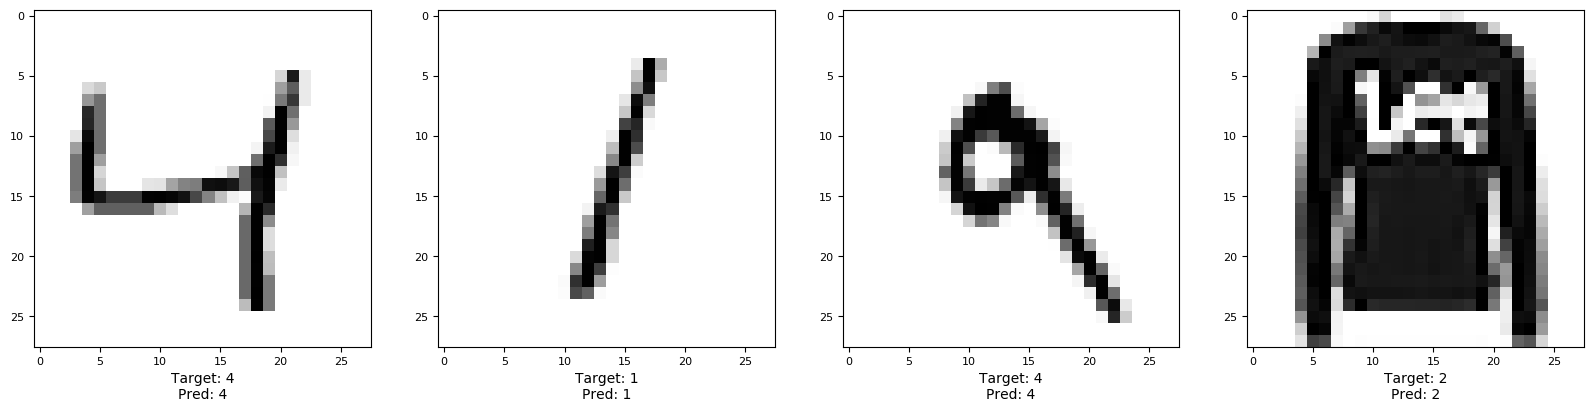

In [7]:
config.viz_datasets(idx=1, model=model)

In [ ]:
config.viz_transforms(idx=5, unc_model=unc_model)

## Generate plots from results

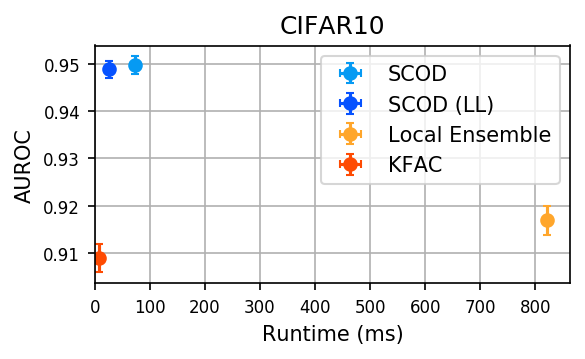

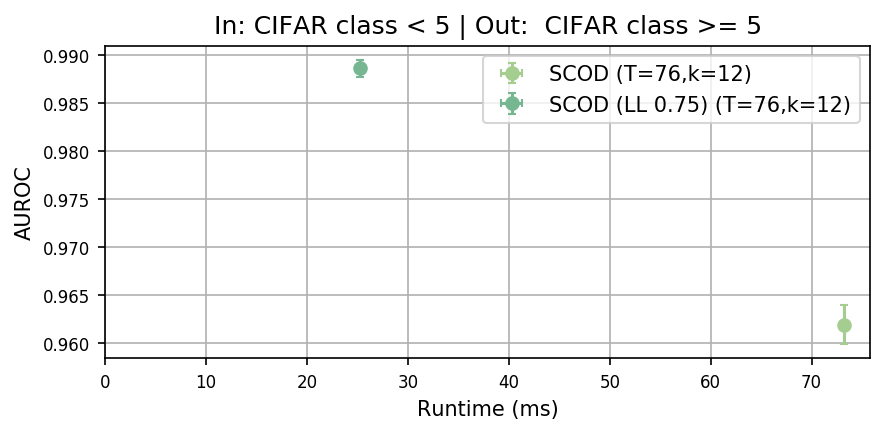

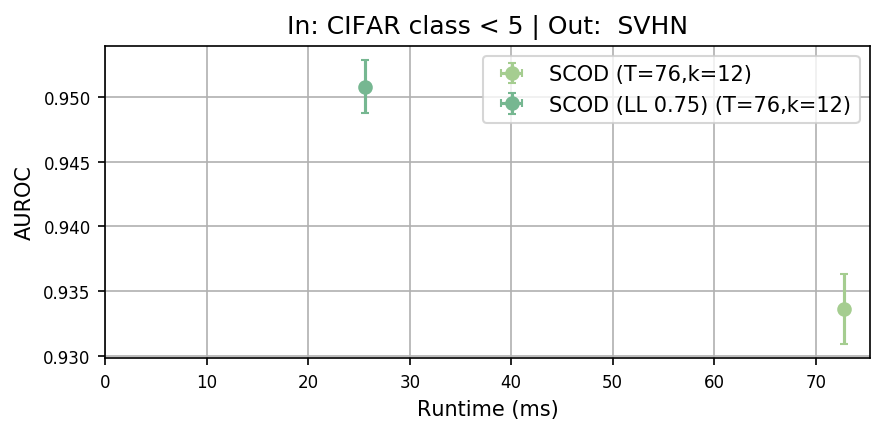

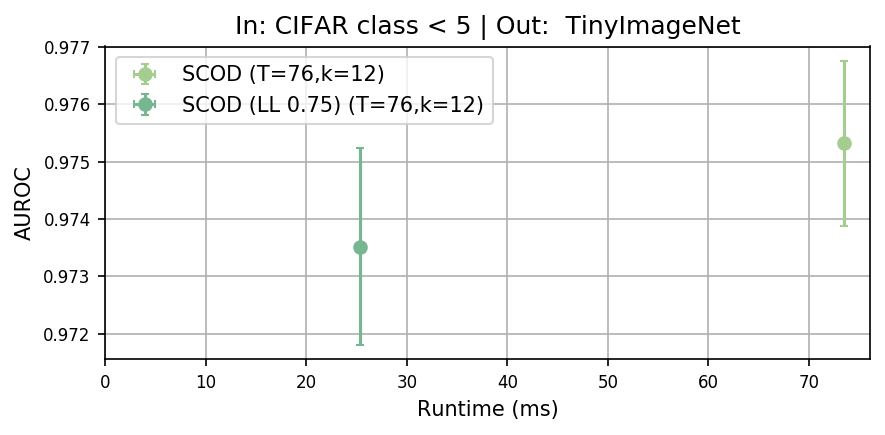

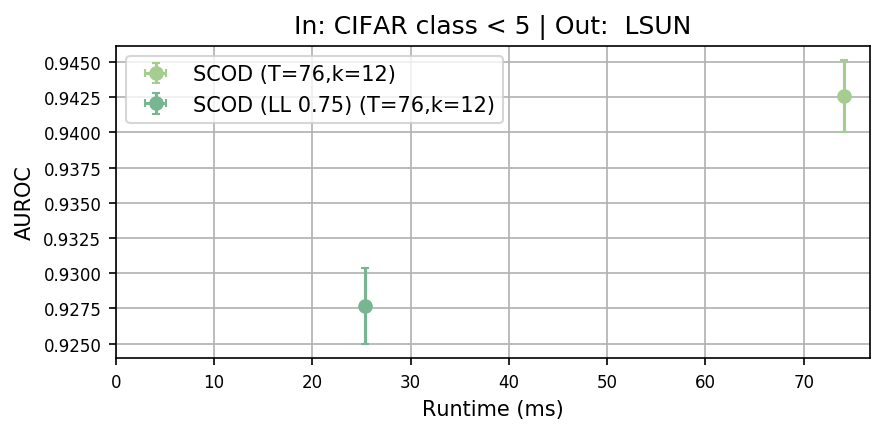

In [5]:
for filename, info in config.plots_to_generate.items():
    summarized_results = info['summary_fn'](results_dict, *info['summary_fn_args'], **info['summary_fn_kwargs'])
    info['plot_fn'](summarized_results, *info['plot_fn_args'], **info['plot_fn_kwargs'])
    if 'legend' in info:
        plt.legend(**info['legend'])
    if 'title' in info:
        plt.title(info['title'])
    plt.tight_layout()
    plt.savefig(os.path.join(EXP_FOLDER,filename))
    plt.show()

# Other visualization tools

### Histograms by technique

In [62]:
results_dict['SCOD']['train']['uncs'].shape

(1000, 1)

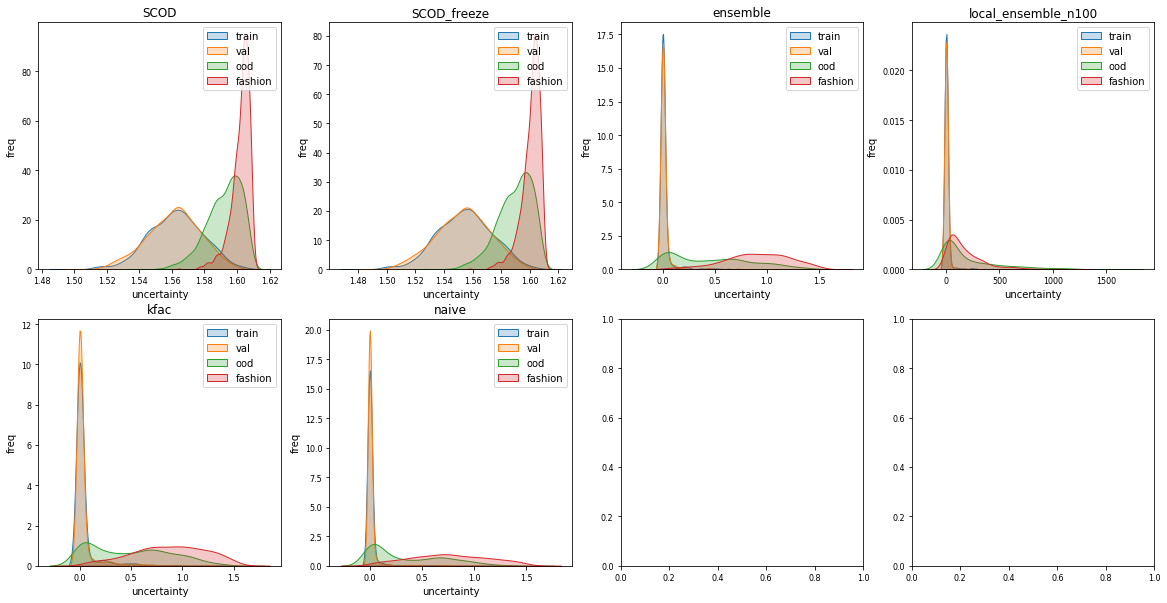

In [16]:
n_techniques = len(config.keys_to_compare)
max_cols = 4
n_rows = int(np.ceil(n_techniques/max_cols))
n_cols = min(max_cols, n_techniques)
fig, axes = plt.subplots(n_rows,n_cols,figsize=[5*n_cols, 5*n_rows])
axes = axes.flatten()
for i, name in enumerate(config.keys_to_compare):
    if name not in results_dict:
        continue
    results = results_dict[name]
    
    plot_histogram(axes[i], results)
    axes[i].set_title(name)
    
plt.show()

### Scatterplots of Uncertainty vs Error

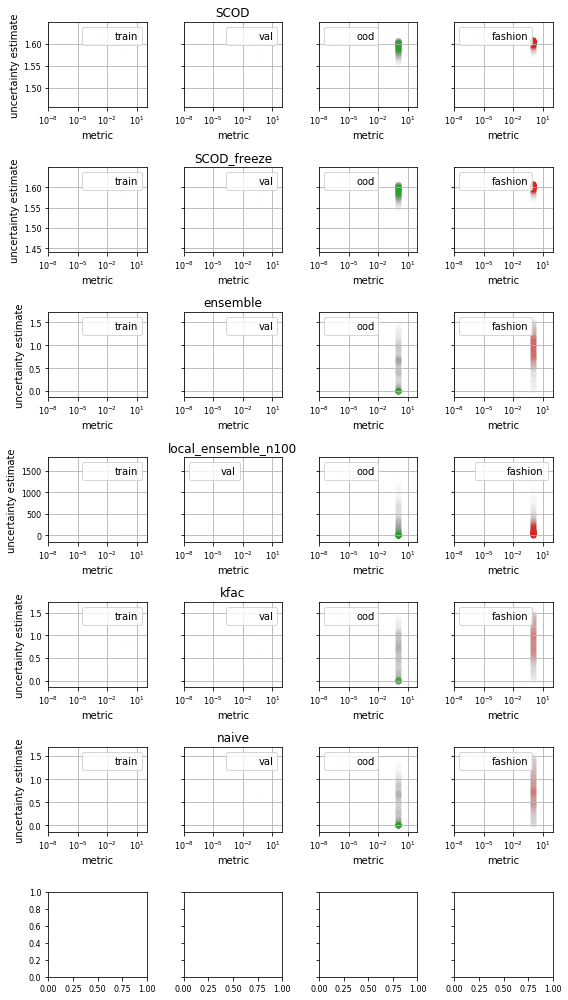

In [17]:
n_techniques = len(config.keys_to_compare)
n_datasets = len(config.test_dataset_args)
fig, axes = plt.subplots(n_techniques,n_datasets,figsize=[2*n_datasets, 2*n_techniques], sharey='row')
for i, name in enumerate(config.keys_to_compare):
    if name not in results_dict:
        continue
    results = results_dict[name]
    plot_scatter(axes[i], results)
    axes[i][n_datasets//2 + n_datasets%2 - 1].set_title(name)
    
plt.tight_layout()

/home/apoorva/.virtualenvs/default/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/apoorva/.virtualenvs/default/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


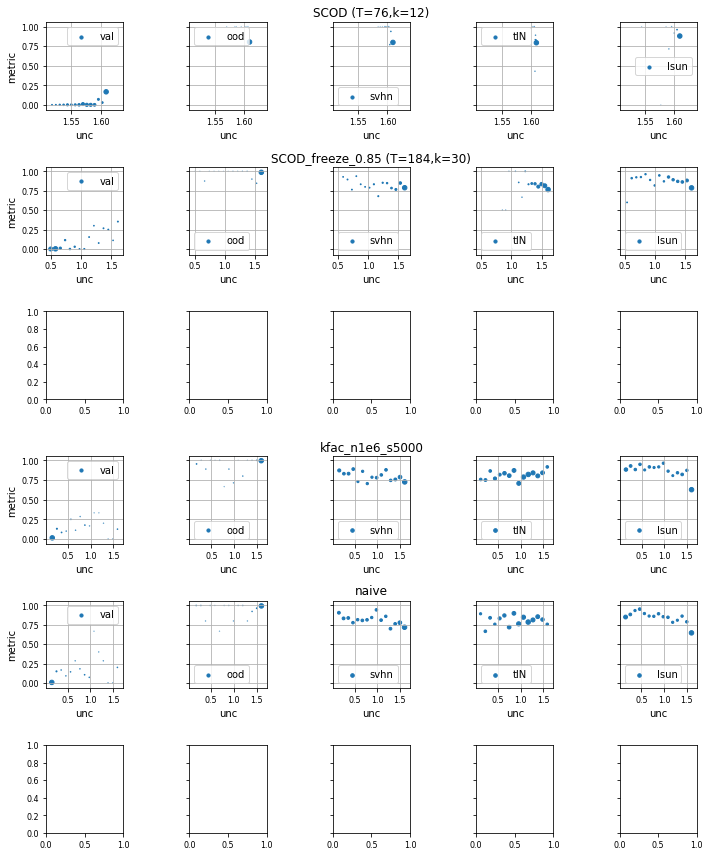

In [8]:
n_techniques = len(config.keys_to_compare)
n_datasets = len(config.test_dataset_args)
fig, axes = plt.subplots(n_techniques,n_datasets,figsize=[2*n_datasets, 2*n_techniques], sharey='row', sharex='row')
for i, name in enumerate(config.keys_to_compare):
    if name not in results_dict:
        continue
    results = results_dict[name]
    plot_binned_by_unc(axes[i], results)
    axes[i][n_datasets//2 + n_datasets%2 - 1].set_title(name)
    
plt.tight_layout()

### Compare OoD performance vs Runtime

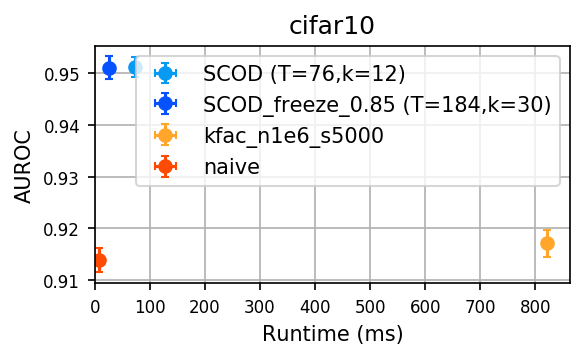

In [6]:
summary = summarize_ood_results(results_dict, config.in_dist_splits, config.out_dist_splits,
                                keys_to_compare = config.keys_to_compare)

plot_perf_vs_runtime(summary,
                  colors=config.colors, figsize=[4,2.5], dpi=150, normalize_x=True)
plt.title(EXP_FOLDER)
plt.legend()
plt.tight_layout()

In [ ]:
@interact(x=(0.0,config.err_thresh*5, config.err_thresh/10.))
def g(x=config.err_thresh):
    summary = summarize_ood_results_by_error(results_dict, config.splits_to_use, x,
                                keys_to_compare = config.keys_to_compare)

    
    plot_perf_vs_runtime(summary,
                  colors=config.colors, figsize=[4,2.5], dpi=150, normalize_x=True)
    plt.legend()


### Noise analysis

In [ ]:
if "transforms" not in dir(config):
    raise NameError("No transforms to visualize for this experiment")

transforms_results_dict = {}
folder_path = os.path.join(EXP_FOLDER, "results_transforms","*")
for filename in glob.glob(folder_path):
    name = os.path.basename(filename)
    transforms_results_dict[name] = torch.load(filename)
    
plot_transform_sweep(transforms_results_dict)

### Visualize Runtime Performance

In [ ]:
plot_times(results_dict, keys_to_compare=config.keys_to_compare, colors=config.colors)